Build A Basic Chatbot with LangGraph

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list, add_messages]



In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [5]:
## Node Functionality
def chatbot(state: State) -> State:
    return {"messages":[llm.invoke(state["messages"])]}

In [6]:
graph_builder = StateGraph(State)

## adding node
graph_builder.add_node("llmchatbot", chatbot)

## adding edges
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

## compile the graph
graph=graph_builder.compile()

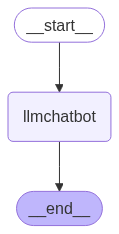

In [7]:
## visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
response = graph.invoke({"messages":"Hi"})

In [9]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [10]:
for event in graph.stream({"messages":"Hi how are you?"}):
    for value in event.values():
            print(value["messages"][-1].content)

I'm just a language model, I don't have feelings or emotions like humans do, but I'm here to help you with any questions or tasks you may have! It's great to have a conversation with you.


Chatbot with Tool

In [10]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [29]:
## custom function
def multiply(a: int, b: int) -> int:
    """ Multiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: Product of a and b
    """
    return a * b

In [30]:
tools=[tool,multiply]

In [31]:
llm_with_tool=llm.bind_tools(tools)

In [32]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002360409EA50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002360409F620>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [ ]:
## Stategraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistance is a tool call -> tools_condition route to tools
    # If the latest message (result) from assistance is not a tool call -> tools_condition route to END
   tools_condition 
)
builder.add_edge("tools", END)

## complile the graph
graph=builder.compile()

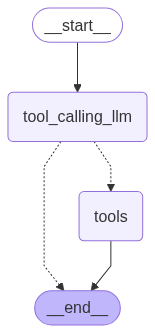

In [42]:
## visualize the graph
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
response=graph.invoke({"messages":"what is the recent AI news?"})

In [24]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/business/us-ai-startups-see-funding-surge-while-more-vc-funds-struggle-raise-data-shows-2025-07-15/", "title": "US AI startups see funding surge while more VC funds struggle to raise, data shows - Reuters", "score": 0.694241, "published_date": "Tue, 15 Jul 2025 04:06:00 GMT", "content": "This year’s boom has been driven largely by major AI investments and bold bets from big tech companies, a wave of activity set off by the debut of ChatGPT in late 2022. In the past three months alone, $69.9 billion was invested in U.S. startups.\\n\\nStandout deals included OpenAI’s $40 billion round and Meta’s (META.O), opens new tab$14.3 billion purchase of a stake in Scale AI.\\n\\nAdvertisement · Scroll to continue [...] - U.S. startup funding surged 75.6% in the first half of 2025, thanks to the continued AI boom, putting it on track for its second-best year ever, ev

In [25]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is the recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (z5sywafqm)
 Call ID: z5sywafqm
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/business/us-ai-startups-see-funding-surge-while-more-vc-funds-struggle-raise-data-shows-2025-07-15/", "title": "US AI startups see funding surge while more VC funds struggle to raise, data shows - Reuters", "score": 0.694241, "published_date": "Tue, 15 Jul 2025 04:06:00 GMT", "content": "This year’s boom has been driven largely by major AI investments and bold bets from big tech companies, a wave of activity set of

In [34]:
response=graph.invoke({"messages":"what is 5 multiplied by 2?"})

In [35]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 5 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (w00666vhk)
 Call ID: w00666vhk
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [38]:
response=graph.invoke({"messages":"Give me recent AI news and then multiply 5 by 2?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me recent AI news and then multiply 5 by 2?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (sv0rm1ds4)
 Call ID: sv0rm1ds4
  Args:
    query: recent AI news
  multiply (j14va5k1z)
 Call ID: j14va5k1z
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "AI is rewriting the rules of the insurance industry · IBM Power11 targets enterprise AI adoption with zero-downtime architecture · Google's open MedGemma AI", "score": 0.78886026, "raw_content": null}, {"url": "https://techcrunch.com/category/artificial-intelligence/", "title": "AI News & Artificial

### ReACT  Agent Architecture

In [46]:
## Stategraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistance is a tool call -> tools_condition route to tools
    # If the latest message (result) from assistance is not a tool call -> tools_condition route to END
   tools_condition 
)
builder.add_edge("tools", "tool_calling_llm")

## complile the graph
graph=builder.compile()

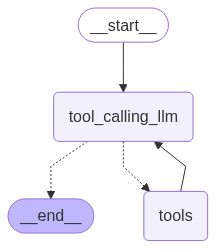

In [47]:
## visualize the graph
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
response=graph.invoke({"messages":"Give me recent AI news and then multiply 5 by 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me recent AI news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (54ma6m2jx)
 Call ID: 54ma6m2jx
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/@ptpchicago/emerging-ai-news-roundup-for-may-and-june-2025-part-1-ai-agents-jobs-impact-and-the-return-of-510b4ff84982", "title": "Emerging AI News Roundup for May and June 2025 Part 1: AI ...", "content": "The New York Times became the most recent during this period, announcing an AI licensing deal with Amazon even as its suit against OpenAI heats up (see Part 2).\n\nAnd speaking of suits, Amazon, Google, Meta, an

### Adding Memory in Agentic Graph

In [51]:
response=graph.invoke({"messages":"Hello my name is John"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello my name is John
================================== Ai Message ==================================

Hello John! Nice to meet you.


In [54]:
response=graph.invoke({"messages":"What is my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================
Tool Calls:
  multiply (ztyartw6g)
 Call ID: ztyartw6g
  Args:
    a: 1
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  tavily_search (k23sat52q)
 Call ID: k23sat52q
  Args:
    query: What is my name
================================= Tool Message =================================
Name: tavily_search

{"query": "What is my name", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/watch?v=_dyvXcv3ej0", "title": "What's My Name (from Descendants 2) (Official Video) - YouTube", "content": "What's My Name (from Descendants 2) (Official Video)\n\nDisneyMusicVEVO\n2449889 likes\n325711551 views\n14 Jun 2017\n\"D

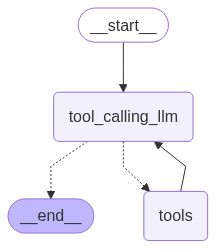

In [64]:
## Stategraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

## Node definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistance is a tool call -> tools_condition route to tools
    # If the latest message (result) from assistance is not a tool call -> tools_condition route to END
   tools_condition 
)
builder.add_edge("tools", "tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
config={"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi my name is JY"}, config=config)

response

{'messages': [HumanMessage(content='Hi my name is JY', additional_kwargs={}, response_metadata={}, id='a6771d37-2c65-43a4-93e4-dc7bc5f4a4f4'),
  AIMessage(content='Nice to meet you, JY! What brings you here today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 2277, 'total_tokens': 2292, 'completion_time': 0.015400171, 'prompt_time': 0.254413168, 'queue_time': 0.07094778099999999, 'total_time': 0.269813339}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--95cb719f-071c-41a8-8a18-480af366ec72-0', usage_metadata={'input_tokens': 2277, 'output_tokens': 15, 'total_tokens': 2292})]}

In [66]:
response['messages'][-1].content

'Nice to meet you, JY! What brings you here today?'

In [67]:
response = graph.invoke({"messages":"Hey what is my name"}, config=config)

In [68]:
response['messages'][-1].content

'Your name is JY.'

In [71]:
response = graph.invoke({"messages":"Hey do you remember my name"}, config=config)

In [72]:
response['messages'][-1].content

'Yes, I remember that your name is JY.'

### Streaming

In [73]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [74]:
def superbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}   

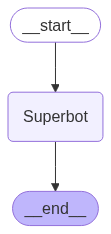

In [77]:
graph=StateGraph(State)

## add node
graph.add_node("Superbot", superbot)

## add edges
graph.add_edge(START, "Superbot")
graph.add_edge("Superbot", END)

graph_builder=graph.compile(checkpointer=memory)

## display the graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [78]:
## Invocation

config = {"configurable":{"thread_id":"1"}}

graph_builder.invoke({"messages":"Hi my name is JY and I love football"}, config=config)

{'messages': [HumanMessage(content='Hi my name is JY and I love football', additional_kwargs={}, response_metadata={}, id='33029a09-7d92-4b86-bf18-a58b92958e29'),
  AIMessage(content="Nice to meet you JY! Football is an amazing sport, isn't it? Which team do you support? Do you have a favorite player or a special memory related to football?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 20, 'total_tokens': 58, 'completion_time': 0.043674987, 'prompt_time': 0.010420285, 'queue_time': 2.3472976930000002, 'total_time': 0.054095272}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2c739492-1d3f-463c-a985-9468136dd097-0', usage_metadata={'input_tokens': 20, 'output_tokens': 38, 'total_tokens': 58})]}

### Streaming
* values: This streams the full state of the graph after each node is called.
* updates: This stream updates to the state of the graph after each node is called.

In [80]:
## Invocation

config = {"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"Hi my name is JY and I love football"}, config=config, stream_mode="updates"):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content="Hi JY! It's great to meet you! Football is an amazing sport, isn't it? Which team do you support? Are you a big fan of a particular player or league? I'm excited to chat with you about football!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 89, 'total_tokens': 139, 'completion_time': 0.051986887, 'prompt_time': 0.023349355, 'queue_time': 0.048613277999999996, 'total_time': 0.075336242}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ad6ac6f5-046a-43f1-ae3d-2724c459e0f6-0', usage_metadata={'input_tokens': 89, 'output_tokens': 50, 'total_tokens': 139})]}}


In [81]:
for chunk in graph_builder.stream({"messages":"Hi my name is JY and I love football"}, config=config, stream_mode="values"):
    print(chunk)


{'messages': [HumanMessage(content='Hi my name is JY and I love football', additional_kwargs={}, response_metadata={}, id='0ca1c177-006c-4ab2-a82a-f4d552fac895'), AIMessage(content="Hi JY! It's great to meet you! Football is an amazing sport, isn't it? Which team do you support? Are you a big fan of a particular player or league? I'm excited to chat with you about football!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 20, 'total_tokens': 70, 'completion_time': 0.051995393, 'prompt_time': 0.00415759, 'queue_time': 0.24721869000000002, 'total_time': 0.056152983}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2b19cc68-cb6a-490a-9b28-2f32d61e9d46-0', usage_metadata={'input_tokens': 20, 'output_tokens': 50, 'total_tokens': 70}), HumanMessage(content='Hi my name is JY and I love football', additional_kwargs={}, response_metadata={}

In [85]:
## Invocation

config = {"configurable":{"thread_id":"5"}}

for chunk in graph_builder.stream({"messages":"Hi my name is JY and I love football"}, config, stream_mode="updates"):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content="Hi JY! Nice to meet you! Football is a great passion to have! Which team do you support? Do you have a favorite player or a memorable match that you'll always cherish? Let's chat about football!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 20, 'total_tokens': 66, 'completion_time': 0.048206726, 'prompt_time': 0.003192997, 'queue_time': 0.048657833, 'total_time': 0.051399723}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4bcf5ea1-a2da-4144-819f-bbb53208cf7e-0', usage_metadata={'input_tokens': 20, 'output_tokens': 46, 'total_tokens': 66})]}}


In [86]:
for chunk in graph_builder.stream({"messages":"I also love basketball"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is JY and I love football', additional_kwargs={}, response_metadata={}, id='9c458c65-9e6e-41aa-8470-95f442b0cce8'), AIMessage(content="Hi JY! Nice to meet you! Football is a great passion to have! Which team do you support? Do you have a favorite player or a memorable match that you'll always cherish? Let's chat about football!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 20, 'total_tokens': 66, 'completion_time': 0.048206726, 'prompt_time': 0.003192997, 'queue_time': 0.048657833, 'total_time': 0.051399723}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4bcf5ea1-a2da-4144-819f-bbb53208cf7e-0', usage_metadata={'input_tokens': 20, 'output_tokens': 46, 'total_tokens': 66}), HumanMessage(content='I also love basketball', additional_kwargs={}, response_metadata={}, id='26ef453e-99c9-4

In [87]:
## Invocation

config = {"configurable":{"thread_id":"6"}}

async for event in graph_builder.astream_events({"messages":["Hi my name is JY and I love football"]}, config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi my name is JY and I love football']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'bfb4b2fe-c528-44cc-923d-8f6c6cc76b19', 'metadata': {'thread_id': '6'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is JY and I love football', additional_kwargs={}, response_metadata={}, id='ae4ef91a-c32f-4a3d-b521-3ca001c125e7')]}}, 'name': 'Superbot', 'tags': ['graph:step:1'], 'run_id': '2b561302-aadf-4e98-923f-7f3127538b6c', 'metadata': {'thread_id': '6', 'langgraph_step': 1, 'langgraph_node': 'Superbot', 'langgraph_triggers': ('branch:to:Superbot',), 'langgraph_path': ('__pregel_pull', 'Superbot'), 'langgraph_checkpoint_ns': 'Superbot:c248a5fc-5fb4-4f14-236a-d09714be9a16'}, 'parent_ids': ['bfb4b2fe-c528-44cc-923d-8f6c6cc76b19']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi my name is JY and I love football', additional_kwargs=